# Anomaly maps

In this notebook, I create anomaly maps of multiple climatic variables to visually understand the population outbreaks in the Fringilla insect data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from datetime import datetime, timedelta

### Importing CRU TS data

The Climate Research Unit gridded Time Series (CRU TS) is a widely used climate dataset with monthly resolution on a 0.5° latitude by 0.5° longitude grid over all land domains of the world except Antarctica. The dataset is introduced in this [paper](https://doi.org/10.1038/s41597-020-0453-3).

In [2]:
# load data from netCDF file
# temperature:
cru_ts_tmp = Dataset('../../data/CRU-TS/cru_ts4.05.1901.2020.tmp.dat.nc')
print(cru_ts_tmp)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.4
    title: CRU TS4.05 Mean Temperature
    institution: Data held at British Atmospheric Data Centre, RAL, UK.
    source: Run ID = 2103051243. Data generated from:tmp.2103041709.dtb
    history: Fri  5 Mar 13:25:53 GMT 2021 : User harry : Program makegridsauto.for called by update.for
    references: Information on the data is available at http://badc.nerc.ac.uk/data/cru/
    comment: Access to these data is available to any registered CEDA user.
    contact: support@ceda.ac.uk
    dimensions(sizes): lon(720), lat(360), time(1440)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 time(time), float32 tmp(time, lat, lon), int32 stn(time, lat, lon)
    groups: 


In [3]:
# precipitation:
cru_ts_pre = Dataset('../../data/CRU-TS/cru_ts4.05.1901.2020.pre.dat.nc')
print(cru_ts_pre)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.4
    title: CRU TS4.05 Precipitation
    institution: Data held at British Atmospheric Data Centre, RAL, UK.
    source: Run ID = 2103051243. Data generated from:pre.2103041709.dtb
    history: Fri  5 Mar 14:41:58 GMT 2021 : User harry : Program makegridsauto.for called by update.for
    references: Information on the data is available at http://badc.nerc.ac.uk/data/cru/
    comment: Access to these data is available to any registered CEDA user.
    contact: support@ceda.ac.uk
    dimensions(sizes): lon(720), lat(360), time(1440)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 time(time), float32 pre(time, lat, lon), int32 stn(time, lat, lon)
    groups: 


In [14]:
# get the data
# NOTE: taking ultimate year and just every 10th coord
# due to computing power limitations
s = 1
pre = cru_ts_pre.variables['pre'][-1:,::s,::s]
tmp = cru_ts_tmp.variables['tmp'][-1:,::s,::s]
lon = cru_ts_tmp.variables['lon'][::s]
lat = cru_ts_tmp.variables['lat'][::s]
print(tmp.shape)
print(lon.shape) # from -180 to 179
print(lat.shape) # from -90 to 90 (including 0°)

(1, 360, 720)
(720,)
(360,)


In [15]:
# import time var & convert into datetime object
time = cru_ts_tmp.variables['time'][-1:]

dtime = []
start = datetime(1900, 1, 1)
for t in time:
    delta = timedelta(days=int(t))
    dtime.append(start + delta)

In [16]:
dtime

[datetime.datetime(2020, 12, 16, 0, 0)]

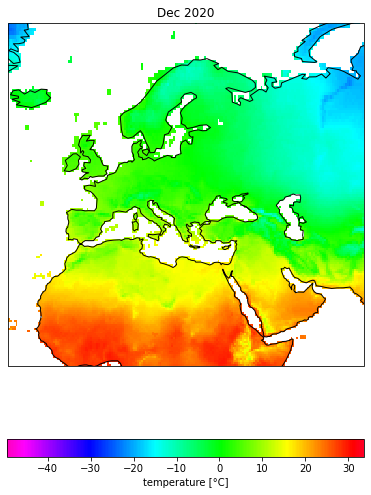

In [49]:
# plotting

# The data is defined in lat/lon coordinate system, so PlateCarree() is the
# appropriate transformation choice.
# (https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html)
data_crs = ccrs.PlateCarree()
v = 10

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection=ccrs.Miller())
ax.set_extent([-25, 70, 5, 70])
ax.set_title(dtime[0].strftime('%b %Y'))
pcm = ax.pcolormesh(lon, lat, tmp[0], # alternatively: ax.contourf()
                    transform=data_crs, cmap='gist_rainbow_r',
                    rasterized=True, shading='nearest') #vmin=-v, vmax=v)
cb = fig.colorbar(pcm, orientation='horizontal', shrink=0.4)
ax.add_feature(cfeature.COASTLINE)
cb.set_label('temperature [°C]')
fig.savefig(
    '../figs/kaliningrad/test.pdf', bbox_inches='tight'
)

In [ ]:
# anomalies in units of standard deviation!